In [9]:
import torch
N = 5
d = 16
Q = torch.randn(N, d).cuda()
K = torch.randn(N, d).cuda()
V = torch.randn(N, d).cuda()
a = (Q @ K.mT).exp()
out = (a/a.sum(-1, keepdim=True)) @ V

In [13]:
inner = Q @ K.mT
acc = 1 + inner
v = torch.tensor(1.0).cuda()
for n in range(2, 30):
    v = v * n
    acc += inner**n / v

In [17]:
inner**3

tensor([[-1.6819e+01,  1.4627e+00,  1.3510e+01, -3.9191e+02, -5.6896e+00],
        [-5.0830e+01, -1.1046e+02, -6.8325e+00, -9.1999e+00, -3.4640e+01],
        [-3.0827e+02, -6.7952e+00,  1.7742e+02, -9.5651e+01, -1.4516e+02],
        [ 2.4230e-01,  4.2880e-02,  8.6232e+00,  7.0160e+01,  1.1383e+00],
        [ 2.9364e-01,  7.2789e-03, -5.5644e+00,  3.8467e-03,  3.2322e+01]],
       device='cuda:0')

In [ ]:
inner**3

In [ ]:
acc2 = 1 + inner
v = torch.tensor(1.0).cuda()
for n in range(2, 30):
    v = v * n
    acc += inner**n / v

In [14]:
a

tensor([[7.7142e-02, 3.1116e+00, 1.0823e+01, 6.6344e-04, 1.6776e-01],
        [2.4617e-02, 8.2454e-03, 1.4994e-01, 1.2302e-01, 3.8395e-02],
        [1.1647e-03, 1.5046e-01, 2.7566e+02, 1.0324e-02, 5.2185e-03],
        [1.8653e+00, 1.4191e+00, 7.7729e+00, 6.1832e+01, 2.8409e+00],
        [1.9438e+00, 1.2139e+00, 1.6999e-01, 1.1696e+00, 2.4178e+01]],
       device='cuda:0')

In [15]:
acc

tensor([[7.7142e-02, 3.1116e+00, 1.0823e+01, 6.6487e-04, 1.6776e-01],
        [2.4616e-02, 8.2457e-03, 1.4994e-01, 1.2302e-01, 3.8395e-02],
        [1.1332e-03, 1.5046e-01, 2.7566e+02, 1.0324e-02, 5.2235e-03],
        [1.8653e+00, 1.4191e+00, 7.7729e+00, 6.1832e+01, 2.8409e+00],
        [1.9438e+00, 1.2139e+00, 1.6999e-01, 1.1696e+00, 2.4178e+01]],
       device='cuda:0')

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import os
os.environ["HF_HOME"] = "./cache"

with open("./.env", "r") as f:
    token = f.read()

import torch
import transformers
pipeline = transformers.pipeline(
    "text-generation", model="meta-llama/Meta-Llama-3-8B", model_kwargs={"torch_dtype": torch.bfloat16, "cache_dir": "./cache"}, device_map="cuda:0", token=token
)
# pipeline = transformers.pipeline(
#     "text-generation", model="meta-llama/Meta-Llama-3-70B", model_kwargs={"torch_dtype": torch.bfloat16, "cache_dir": "./cache"}, device_map="auto", token=token
# )
# pipeline = transformers.pipeline(
#     "text-generation", model="google/gemma-7b", model_kwargs={"torch_dtype": torch.bfloat16, "cache_dir": "./cache"}, device_map="cuda:0", token=token, trust_remote_code=True
# )

Loading checkpoint shards: 100%|██████████| 4/4 [00:17<00:00,  4.40s/it]
Device set to use cuda:0


In [17]:
from typing import Callable, List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn

from transformers.activations import ACT2FN
from transformers.cache_utils import Cache, DynamicCache, StaticCache
from transformers.generation import GenerationMixin
from transformers.modeling_attn_mask_utils import AttentionMaskConverter
from transformers.modeling_flash_attention_utils import FlashAttentionKwargs
from transformers.modeling_outputs import (
    BaseModelOutputWithPast,
    CausalLMOutputWithPast,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutputWithPast,
    TokenClassifierOutput,
)
from transformers.modeling_rope_utils import ROPE_INIT_FUNCTIONS
from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS, PreTrainedModel
from transformers.processing_utils import Unpack
from transformers.pytorch_utils import ALL_LAYERNORM_LAYERS
from transformers.utils import (
    LossKwargs,
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
from transformers.utils.deprecation import deprecate_kwarg
from transformers.models.llama.configuration_llama import LlamaConfig


logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "meta-llama/Llama-2-7b-hf"
_CONFIG_FOR_DOC = "LlamaConfig"

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

def eager_attention_forward(
    module: nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    **kwargs,
):
    key_states = repeat_kv(key, module.num_key_value_groups)
    value_states = repeat_kv(value, module.num_key_value_groups)

    attn_weights = torch.matmul(query, key_states.transpose(2, 3)) * scaling
    if attention_mask is not None:
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query.dtype)
    attn_weights = nn.functional.dropout(attn_weights, p=dropout, training=module.training)
    attn_output = torch.matmul(attn_weights, value_states)
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weights

class LlamaAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: LlamaConfig, layer_idx: int):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        self.num_key_value_groups = config.num_attention_heads // config.num_key_value_heads
        self.scaling = self.head_dim**-0.5
        self.attention_dropout = config.attention_dropout
        self.is_causal = True

        self.q_proj = nn.Linear(
            config.hidden_size, config.num_attention_heads * self.head_dim, bias=config.attention_bias
        )
        self.k_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.attention_bias
        )
        self.v_proj = nn.Linear(
            config.hidden_size, config.num_key_value_heads * self.head_dim, bias=config.attention_bias
        )
        self.o_proj = nn.Linear(
            config.num_attention_heads * self.head_dim, config.hidden_size, bias=config.attention_bias
        )

        self.num_iters = 100
        self.avg_mags = [[] for i in range(0, self.num_iters)]

    def forward(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: Tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_value: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs: Unpack[FlashAttentionKwargs],
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        dev = hidden_states.device
        hidden_states = hidden_states.to(self.q_proj.weight.device)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        cos = cos.to(query_states.device)
        sin = sin.to(query_states.device)
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_value is not None:
            # sin and cos are specific to RoPE models; cache_position needed for the static cache
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

        attention_interface: Callable = eager_attention_forward
        if self.config._attn_implementation != "eager":
            if self.config._attn_implementation == "sdpa" and kwargs.get("output_attentions", False):
                logger.warning_once(
                    "`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to "
                    'eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.'
                )
            else:
                attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]






        # Repeat kv for grouped query attn
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        query_states = query_states.contiguous()
        key_states = key_states.contiguous()
        value_states = value_states.contiguous()

        # attn_output = torch.nn.functional.scaled_dot_product_attention(
        #     query_states.contiguous(),
        #     key_states.contiguous(),
        #     value_states.contiguous(),
        #     attn_mask=causal_mask,
        #     dropout_p=0.0,
        #     scale=self.scaling,
        #     is_causal=True,
        # )
        # attn_output = attn_output.transpose(1, 2).contiguous()
        # attn_weights = None

        is_causal = None
        
        # We dispatch to SDPA's Flash Attention or Efficient kernels via this `is_causal` if statement instead of an inline conditional assignment
        # in SDPA to support both torch.compile's dynamic shapes and full graph options. An inline conditional prevents dynamic shapes from compiling.
        # Note that it is important to check first for the shape, otherwise compile will fail with `argument 'is_causal' must be bool, not SymBool`
        if is_causal is None:
            is_causal = query_states.shape[2] > 1 and attention_mask is None

        # Shapes (e.g. query.shape[2]) are tensors during jit tracing, resulting in `is_causal` being a tensor.
        # We convert it to a bool for the SDPA kernel that only accepts bools.
        if torch.jit.is_tracing() and isinstance(is_causal, torch.Tensor):
            is_causal = is_causal.item()

        L, S = query_states.size(-2), key_states.size(-2)
        attn_bias = torch.zeros(L, S, dtype=query_states.dtype, device=query_states.device)
        if is_causal:
            temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0).to(query_states.device)
            attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
            attn_bias.to(query_states.dtype)

        # Inner product
        # print(query_states.shape, key_states.shape, value_states.shape)
        attn_weights = (query_states @ key_states.mT) * self.scaling

        # Mask attn matrix
        attn_weights_SM = attn_weights + attn_bias

        # Attn
        attn_weights_SM = attn_weights_SM.softmax(-1)

        # SUbtract max for stability
        # attn_weights = attn_weights - attn_weights.max(-1, keepdims=True).values
        mask_ = (attn_bias == 0).to(query_states.device)
        attn_weights = (attn_weights * mask_).to(torch.float64)

        # Exponential
        attn_weights_ = attn_weights.clone() + 1
        cur = torch.tensor([1], dtype=torch.float64).to(query_states.device)
        self.avg_mags[0].append(torch.tensor(1, dtype=torch.float64))
        self.avg_mags[1].append((attn_weights * mask_).mean())
        for i in range(2, self.num_iters):
            cur *= i
            c = (attn_weights**i)/cur
            attn_weights_ = attn_weights_ + c
            self.avg_mags[i].append((c*mask_).abs().mean())

        attn_weights_ = attn_weights_ * (attn_bias == 0)

        # Norm
        attn_weights = (attn_weights_ / attn_weights_.sum(-1, keepdims=True)).to(torch.bfloat16)

        attn_output = attn_weights @ value_states

        attn_output = attn_output.transpose(1, 2).contiguous()

        # attn_output, attn_weights = attention_interface(
        #     self,
        #     query_states,
        #     key_states,
        #     value_states,
        #     attention_mask,
        #     dropout=0.0 if not self.training else self.attention_dropout,
        #     scaling=self.scaling,
        #     **kwargs,
        # )

        attn_output = attn_output.reshape(*input_shape, -1).contiguous()
        attn_output = self.o_proj(attn_output)

        attn_output = attn_output.to(dev)

        return attn_output, attn_weights

In [18]:
for i in range(0, len(pipeline.model.model.layers)):
    new_layer = LlamaAttention(pipeline.model.config, layer_idx=i)
    dev = new_layer.q_proj.weight.device
    old_self_attn = pipeline.model.model.layers[i].self_attn
    new_layer.q_proj.weight.data = old_self_attn.q_proj.weight.data
    new_layer.k_proj.weight.data = old_self_attn.k_proj.weight.data
    new_layer.v_proj.weight.data = old_self_attn.v_proj.weight.data
    new_layer.o_proj.weight.data = old_self_attn.o_proj.weight.data
    del pipeline.model.model.layers[i].self_attn
    del old_self_attn
    pipeline.model.model.layers[i].self_attn = new_layer.to(dev)

In [19]:
pipeline("Hello there llama", max_new_tokens=100)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'generated_text': "Hello there llama! I'm just a simple llama who likes to talk to people and have fun. I'm a big fan of the Sims 4 and I'm always up for a game of chess. I'm also a big fan of the Sims 2 and I'm always up for a game of chess.\nI'm a llama who loves to talk to people and have fun. I'm a big fan of the Sims 4 and I'm always up for a game of chess. I'm also a big"}]

Notes:
- layer 0 and layer 31 (last layer) have the most insane decays I've ever seen
- the other layers are pretty normal

In [20]:
# Iterate over all layers and get the magnitudes
all_mags = [] # (layers, num_iters, num_tokens)
for layer in pipeline.model.model.layers:
    all_mags.append(torch.stack([torch.stack(i) for i in layer.self_attn.avg_mags]))
all_mags = torch.stack(all_mags)

# Average over the tokens - per layer values (layers, num_iters)
per_layer_vals = all_mags.mean(-1).cpu().numpy()
# Average over the layer - per token values (num_tokens, num_iters)
per_token_vals = all_mags.mean(0).mT.cpu().numpy()

In [21]:
# 

# Per Layer Observations
Obviously, the first and last layers have a much slower decay than the rest of the terms. The last layer in particular is very interesting as this layer a dropoff much much larger than the rest, making the distribution look completely disjoint from the others.

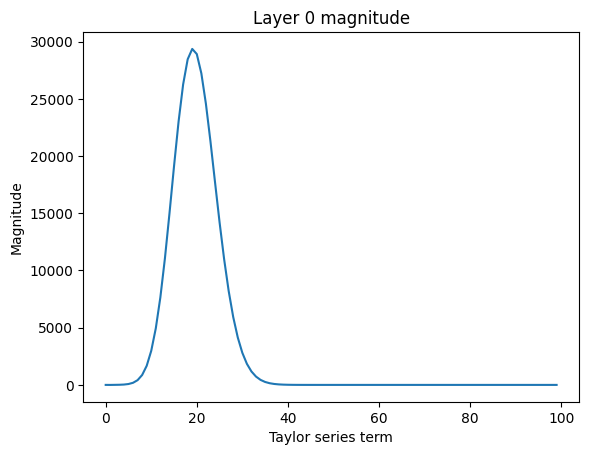

In [22]:
# Remove layer 0 and 1 because the magnitude is massive
plt.plot(per_layer_vals.transpose(-1, -2)[:, :1])
plt.title("Layer 0 magnitude")
plt.xlabel("Taylor series term")
plt.ylabel("Magnitude")
plt.show()

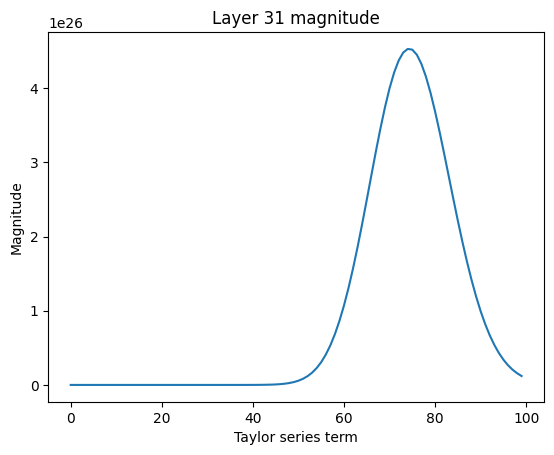

In [23]:
# Remove layer 0 and 1 because the magnitude is massive
layer_layer = per_layer_vals.shape[0]-1
plt.plot(per_layer_vals.transpose(-1, -2)[:, layer_layer:])
plt.title(f"Layer {layer_layer} magnitude")
plt.xlabel("Taylor series term")
plt.ylabel("Magnitude")
plt.show()

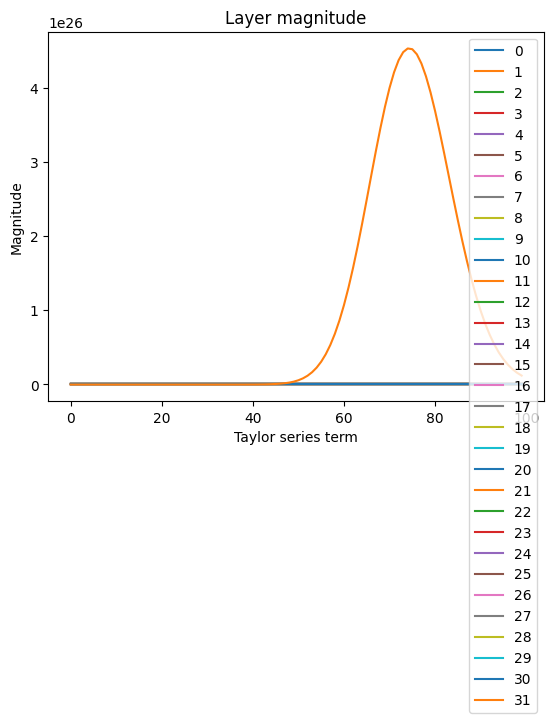

In [29]:
# Remove layer 0 and 1 because the magnitude is massive
plt.plot(per_layer_vals.transpose(-1, -2))
plt.title("Layer magnitude")
plt.xlabel("Taylor series term")
plt.ylabel("Magnitude")
plt.legend([i for i in range(0, per_layer_vals.shape[0])])
plt.show()

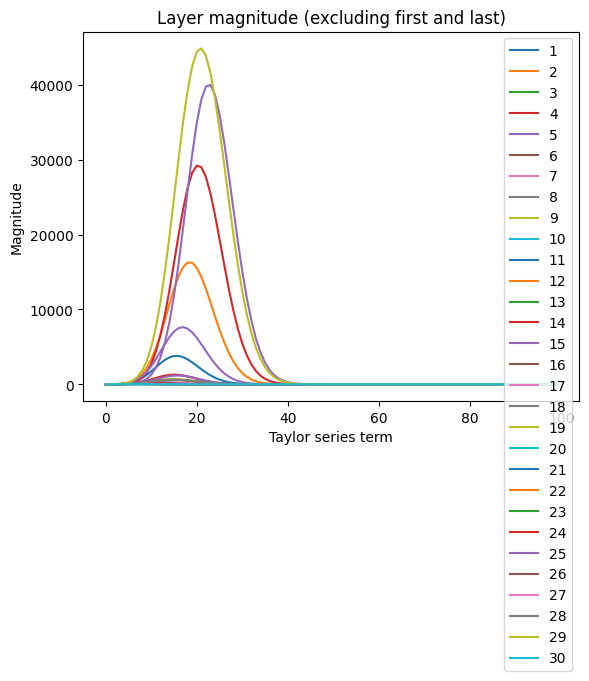

In [ ]:
# Remove layer 0 and 1 because the magnitude is massive
plt.plot(per_layer_vals.transpose(-1, -2)[:, 1:-1])
plt.title("Layer magnitude (excluding first and last)")
plt.xlabel("Taylor series term")
plt.ylabel("Magnitude")
plt.legend([i+1 for i in range(0, per_layer_vals.shape[0]-2)])
plt.show()

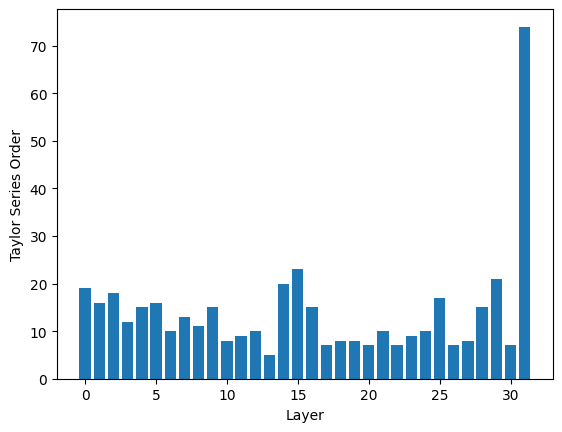

In [ ]:
# What are the orders of each distribution. That is, the order at the peak where the factorial bounds the power.
plt.bar(np.arange(0, per_layer_vals.shape[0]), per_layer_vals.transpose(-1, -2).argmax(0))
plt.title("")
plt.xlabel("Layer")
plt.ylabel("Taylor Series Order")
plt.show()

In [ ]:
# Remove layer 0 and 1 because the magnitude is massive
plt.plot(per_layer_vals.transpose(-1, -2)[:, 1:-1])
plt.title("Layer magnitude (excluding first and last)")
plt.xlabel("Taylor series term")
plt.ylabel("Magnitude")
plt.legend([i+1 for i in range(0, per_layer_vals.shape[0]-2)])
plt.show()

/tmp/ipykernel_599502/1693533401.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(per_layer_vals).transpose(-1, -2))


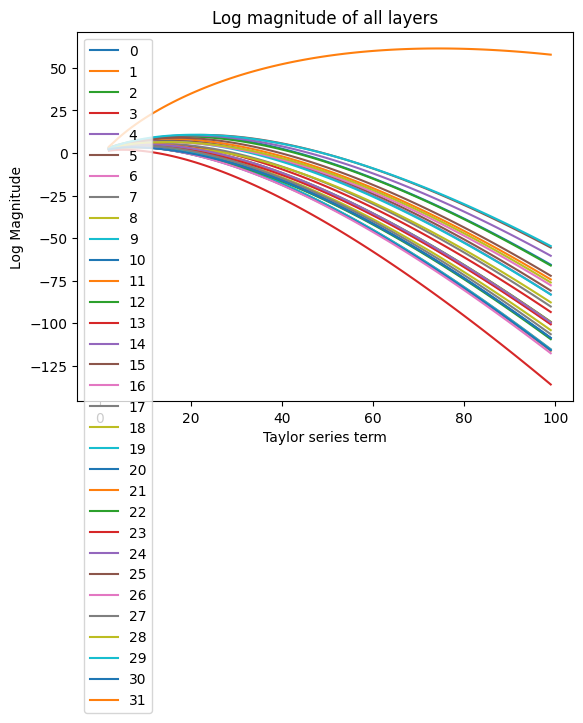

In [31]:
plt.plot(np.log(per_layer_vals).transpose(-1, -2))
plt.title("Log magnitude of all layers")
plt.xlabel("Taylor series term")
plt.ylabel("Log Magnitude")
plt.legend([i for i in range(0, per_layer_vals.shape[0])])
plt.show()

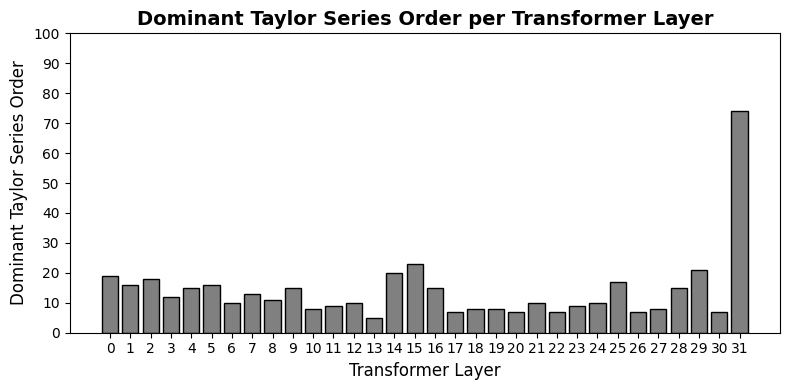

In [65]:
import matplotlib.pyplot as plt
import numpy as np

data_ = per_layer_vals

# Sample plot using provided values
fig, ax = plt.subplots(figsize=(8, 4))

# Main bar plot
ax.bar(
    np.arange(0, data_.shape[0]),
    data_.transpose(-1, -2).argmax(0),
    color='gray',
    edgecolor='black'
)

# Aesthetics and labels
ax.set_title("Dominant Taylor Series Order per Transformer Layer", fontsize=14, fontweight='bold')
ax.set_xlabel("Transformer Layer", fontsize=12)
ax.set_ylabel("Dominant Taylor Series Order", fontsize=12)

# Improve ticks
ax.set_xticks(np.arange(0, data_.shape[0], step=1))
ax.set_yticks(np.arange(0, data_.shape[-1] + 1, step=10))
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout for clean spacing
plt.tight_layout()

# Save or show the figure
plt.savefig("taylor_series_orders.pdf", dpi=600, bbox_inches='tight')
plt.show()


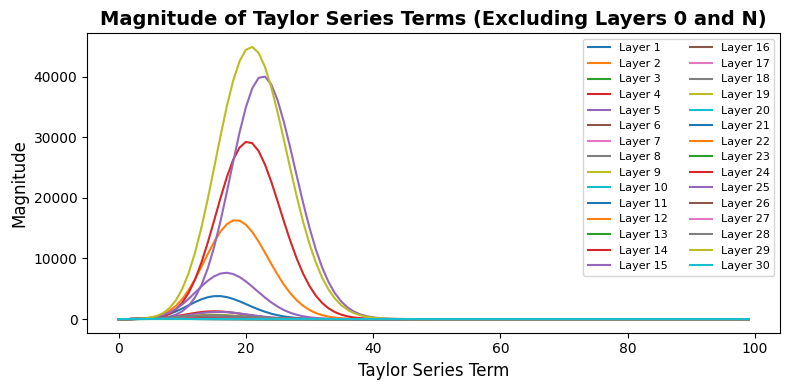

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Exclude first and last layer
data = per_layer_vals.transpose(-1, -2)[:, 1:-1].transpose(-1, -2)

# Plot each layer
ax.plot(data.T, linewidth=1.5)

# Title and axis labels
ax.set_title("Magnitude of Taylor Series Terms (Excluding Layers 0 and N)", fontsize=14, fontweight='bold')
ax.set_xlabel("Taylor Series Term", fontsize=12)
ax.set_ylabel("Magnitude", fontsize=12)

# Legend (layers 1 to N-2)
ax.legend([f"Layer {i}" for i in range(1, per_layer_vals.shape[0]-1)], fontsize=8, ncol=2, loc='upper right')

# Format ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout and save
plt.tight_layout()
plt.show()


/tmp/ipykernel_599502/2699066399.py:4: RuntimeWarning: invalid value encountered in log
  log_data = np.log(per_layer_vals).transpose(-1, -2)


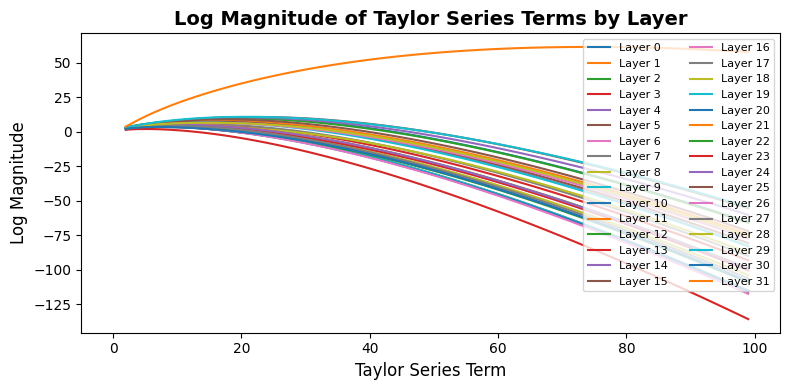

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))

# Compute and plot log magnitude
log_data = np.log(per_layer_vals).transpose(-1, -2)
ax.plot(log_data, linewidth=1.5)

# Title and axis labels
ax.set_title("Log Magnitude of Taylor Series Terms by Layer", fontsize=14, fontweight='bold')
ax.set_xlabel("Taylor Series Term", fontsize=12)
ax.set_ylabel("Log Magnitude", fontsize=12)

# Legend (all layers)
ax.legend([f"Layer {i}" for i in range(per_layer_vals.shape[0])], fontsize=8, ncol=2, loc='upper right')

# Format ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout and save
plt.tight_layout()
plt.savefig("taylor_series_log_magnitude_all_layers.pdf", dpi=300, bbox_inches='tight')
plt.show()


# Per-token observations
it looks like there is some variation in the taylor dropoff for different terms in the sequence

questions:
1. Is this a positional thing?
2. Is this a semantic thing?

/tmp/ipykernel_3131406/2365575241.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(per_token_vals).transpose(-1, -2))


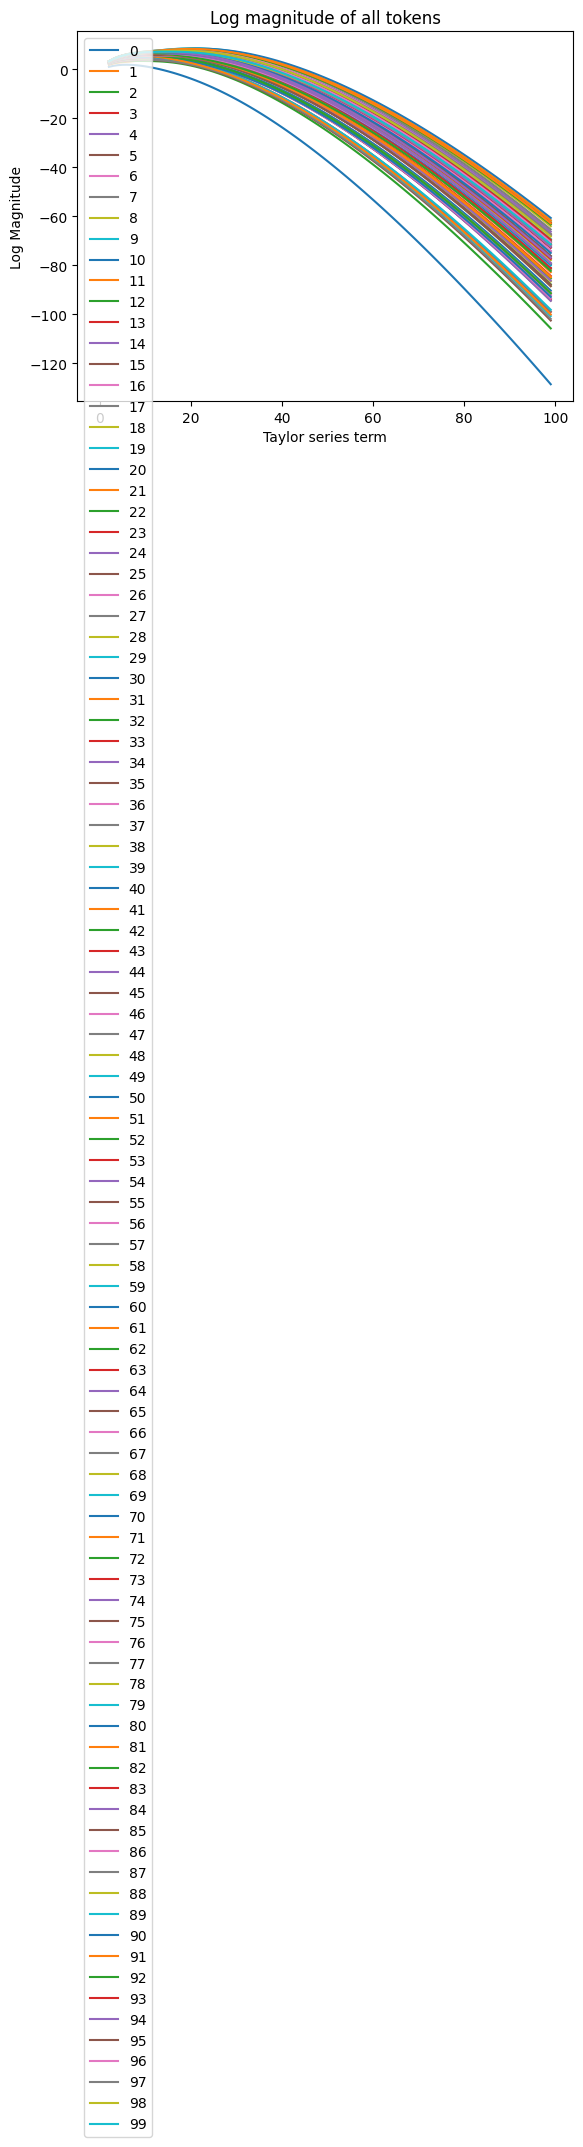

In [15]:
plt.plot(np.log(per_token_vals).transpose(-1, -2))
plt.title("Log magnitude of all tokens")
plt.xlabel("Taylor series term")
plt.ylabel("Log Magnitude")
plt.legend([i for i in range(0, per_token_vals.shape[0])])
plt.show()

/tmp/ipykernel_599502/3374989107.py:4: RuntimeWarning: invalid value encountered in log
  log_data = np.log(per_token_vals).transpose(-1, -2)
/tmp/ipykernel_599502/3374989107.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


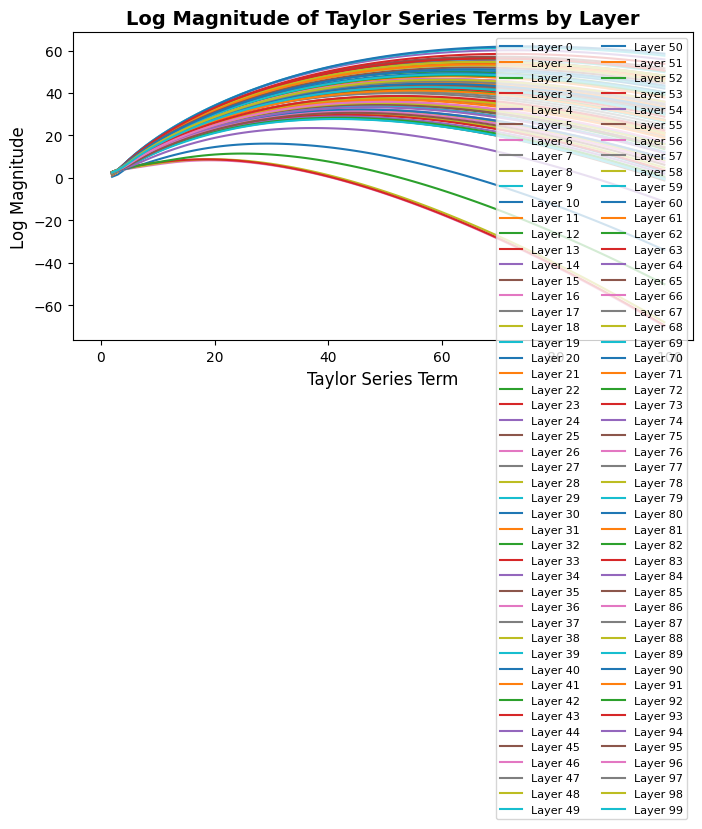

In [54]:
fig, ax = plt.subplots(figsize=(8, 4))

# Compute and plot log magnitude
log_data = np.log(per_token_vals).transpose(-1, -2)
ax.plot(log_data, linewidth=1.5)

# Title and axis labels
ax.set_title("Log Magnitude of Taylor Series Terms by Layer", fontsize=14, fontweight='bold')
ax.set_xlabel("Taylor Series Term", fontsize=12)
ax.set_ylabel("Log Magnitude", fontsize=12)

# Legend (all layers)
ax.legend([f"Layer {i}" for i in range(per_token_vals.shape[0])], fontsize=8, ncol=2, loc='upper right')

# Format ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout and save
plt.tight_layout()
plt.savefig("taylor_series_log_magnitude_all_layers.pdf", dpi=300, bbox_inches='tight')
plt.show()
